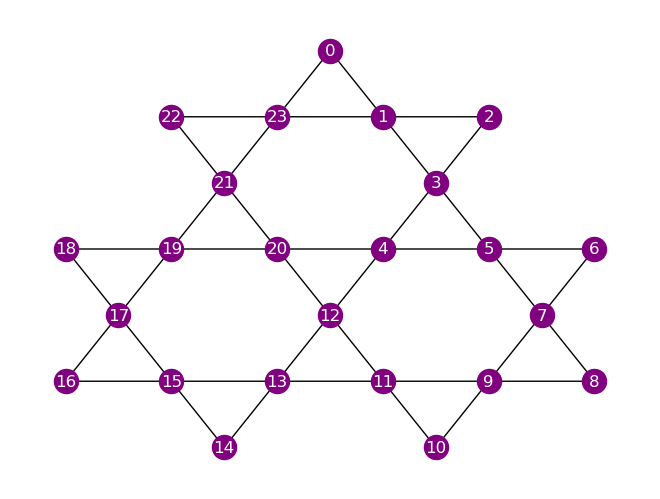

In [1]:
# Kagome lattice consisting of 3 cells, using 24 qubits
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from time import time
from qiskit_nature.problems.second_quantization.lattice import Lattice

num_qubits = 24
# edge weight
t = 1.0

graph_24 = rx.PyGraph(multigraph=False)
graph_24.add_nodes_from(range(num_qubits))

edge_list = [
    (0,1,t),
    (0,23,t),
    (1,2,t),
    (1,3,t),
    (1,23,t),
    (2,3,t),
    (3,4,t),
    (3,5,t),
    (4,5,t),
    (4,12,t),
    (4,20,t),
    (5,6,t),
    (5,7,t),
    (6,7,t),
    (7,8,t),
    (7,9,t),
    (8,9,t),
    (9,10,t),
    (9,11,t),
    (10,11,t),
    (11,12,t),
    (11,13,t),
    (12,13,t),
    (12,20,t),
    (13,14,t),
    (13,15,t),
    (14,15,t),
    (15,16,t),
    (15,17,t),
    (16,17,t),
    (17,18,t),
    (17,19,t),
    (18,19,t),
    (19,20,t),
    (19,21,t),
    (20,21,t),
    (21,22,t),
    (21,23,t),
    (22,23,t)   
]

graph_24.add_edges_from(edge_list)
kagome_3_cell = Lattice(graph_24)
r = np.sqrt(3)
node_pos = {0:[0,3*r],1:[1,2*r],2:[3,2*r],3:[2,r],4:[1,0],5:[3,0],6:[5,0],7:[4,-r],8:[5,-2*r],
           9:[3,-2*r],10:[2,-3*r],11:[1,-2*r],12:[0,-r],13:[-1,-2*r],14:[-2,-3*r],15:[-3,-2*r],
           16:[-5,-2*r],17:[-4,-r],18:[-5,0],19:[-3,0],20:[-1,0],21:[-2,r],22:[-3,2*r],23:[-1,2*r]}
kagome_3_cell.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':node_pos})
plt.show()

In [2]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from heisenberg_model import HeisenbergModel

# Build Hamiltonian from graph edges
heis_24 = HeisenbergModel.uniform_parameters(
    lattice=kagome_3_cell,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_24 = 4 * log_mapper.map(heis_24.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
# ham_24

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector

def W_entangler(circuit,q_array,param_name):
    # takes a quantum circuit and creates a parametrised W state 
    # between the qubits specified in q_array, with parameters specified in a vector param_name
    circuit.x(q_array[0])  # apply NOT to the first qubit in q_array
    k = len(q_array) - 1   # need a number of parameters one less than the number of qubits
    theta = []
    for i in range(k):
        theta.append(Parameter(param_name+'_'+str(i)))
    
    for j in range(k):  # this applies a rotation to qubit at index j+1 in the array 
        circuit.ry(theta[j],q_array[j+1])
        circuit.cz(q_array[j],q_array[j+1])
        circuit.ry(-theta[j],q_array[j+1])
    for j in range(k):  # entangle all the qubits with CNOT gates
        circuit.cx(q_array[j+1],q_array[j])
    return circuit

In [4]:
kagome24 = QuantumCircuit(24)

for i in range(11):
    W_entangler(kagome24,[2*i+1,2*i+2,2*i+3],'t'+str(i))
    
W_entangler(kagome24,[23,0],'t11') # entangle the last (23rd) and first (0th) qubit

print('number and type of gates in the cirucit:', kagome24.count_ops())
print('number of parameters in the circuit:', kagome24.num_parameters)
# kagome24.draw("mpl")

number and type of gates in the cirucit: OrderedDict([('ry', 46), ('cz', 23), ('cx', 23), ('x', 12)])
number of parameters in the circuit: 23


In [5]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=250)

In [6]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/2 * (np.random.rand(self._circuit.num_parameters))
        # x0 = np.pi/4 * np.array([1,0,1,1,0,1,0,1,0,1,0])
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [7]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

In [ ]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
QiskitRuntimeService.save_account(channel="ibm_quantum", token="a25c2de7fba634b2157af2ffb30cdcc9308e14a848e7ab959998e09039d19b4bb8310654409a6be536191b7181d01036b0df144e791d1b9c700281d2d9e8f098",overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

backend = 'simulator_statevector'

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session)
    # Set up algorithm
    custom_vqe = CustomVQE(rt_estimator, kagome24, optimizer, callback=callback)
    # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_24)
end = time()
print(f'execution time (s): {end - start:.2f}')
print(result)

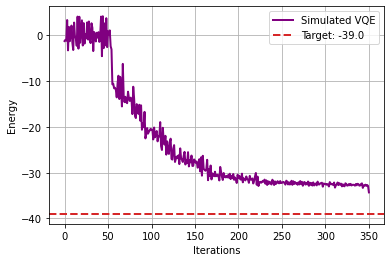

In [9]:
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
gs_energy = -39.0
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
execution time (s): 26374.29
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 300,
    'eigenstate': None,
    'eigenvalue': -34.299,
    'optimal_circuit': None,
    'optimal_parameters': array([ 7.30609385e-01,  4.96782302e-03, -2.36048574e+00,  2.76059088e-02,
        8.38339365e-01,  9.36019419e-01, -7.38877547e-03, -8.18702430e-01,
        3.17053886e+00,  8.22615701e-01,  1.40784112e-05,  8.04994991e-01,
       -1.70654509e-02,  6.14088344e-03, -1.56234434e+00,  7.12219535e-01,
        1.57381198e-02,  7.55085836e-01,  8.22332081e-04,  8.17436446e-01,
        3.91438474e-02,  9.34327779e-01,  1.27093500e-02]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}

In [23]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
QiskitRuntimeService.save_account(channel="ibm_quantum", token="a25c2de7fba634b2157af2ffb30cdcc9308e14a848e7ab959998e09039d19b4bb8310654409a6be536191b7181d01036b0df144e791d1b9c700281d2d9e8f098",overwrite=True)
backend = 'simulator_statevector'
service = QiskitRuntimeService(channel='ibm_quantum')

kagome24 = QuantumCircuit(24)

for i in range(11):
    W_entangler(kagome24,[2*i+1,2*i+2,2*i+3],'t'+str(i))
    
W_entangler(kagome24,[23,0],'t11') # entangle the last (23rd) and first (0th) qubit

with Session(service=service,backend=backend) as session:
    estimator = RuntimeEstimator()
    params = kagome24.parameters
    num_params = len(params)
    x0 = [1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
    # x0 = [1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0] # energy: -36.03
    # x0 = [1,0,1,0,1,1,0,1,0,1,0,1,0,0,2,1,0,1,0,1,0,1,0] # energy: -34
    # x0 = [i%2 for i in range(23)]
    # x0 = [1,0,-3,0,1,1,0,-1,4,1,0,1,0,0,-2,1,0,1,0,1,0,1,0]
    t_dict = {params[i]: x0[i]*np.pi/4 for i in range(len(params))}
    kagome24.assign_parameters(t_dict,inplace=True)

    job = estimator.run([kagome24],[ham_24])
    result = job.result()
    print(result.values[0])

-35.963


In [ ]:
from qiskit import Aer, transpile

sim_statevector = Aer.get_backend('aer_simulator_statevector')
sim_kagome = QuantumCircuit(12)
for i in range(5):      
    W_entangler(sim_kagome,[2*i+1,(2*i+2)%12,(2*i+3)%12],'t'+str(i))

# entangle the last qubit with the first (still free) qubit in the lattice
W_entangler(sim_kagome,[11,0],'t'+str(5))

# use (optimal) ground state parameters and bind them to the circuit
x0 = np.pi/4 * np.array([1,0,1,0,1,0,1,0,1,0,1])

params = sim_kagome.parameters
t_dict = {params[i]: ((i+1)%2)*np.pi/4 for i in range(11)}
sim_kagome.assign_parameters(t_dict,inplace=True)

# save the state vector of the ground state
sim_kagome.save_statevector()

transpile(kagome_ansatz,sim_statevector)

result = sim_statevector.run(sim_kagome,ham_16).result()
statevector = result.get_statevector(sim_kagome)
state_vec_arr = np.asarray(statevector).flatten()

for i in range(len(state_vec_arr)):
    if not state_vec_arr[i] == 0:
        print("%.3f |%s>" % (np.round(state_vec_arr[i],3), format(i,'012b')))

In [14]:
from qiskit import IBMQ

IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

job = provider.runtime.job('cg4r4biuhir4rv1m6ic0')
result = job.result()
print(result)

C:\Users\keckert\AppData\Local\Temp/ipykernel_15768/379544204.py:3: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account() # Load account from disk
C:\Users\keckert\AppData\Local\Temp/ipykernel_15768/379544204.py:3: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account() # Load account from disk


{'values': [-31.580999999999996], 'metadata': [{'variance': 86.0320535, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}]}
